# Finding blobs in 64x64 images using Unet, Conv3d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random

# Get data

Data reading function

In [2]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

In [3]:
def leaky_relu(inp, alpha=0.2):
    return tf.maximum(inp * alpha, inp)
    

Read in blobs tiff

In [4]:
all_dataA=read_tiff('3DBlobsB.tif',6400)
all_dataA=all_dataA.reshape(400,16,64,64)

In [5]:
all_truthsA=read_tiff('3DBlobsMaskTruthB.tif',6400)
all_truthsA=all_truthsA.reshape(400,16,64,64)

In [6]:
all_truthsB=read_tiff('3DBlobsOutlinesTruthB.tif',6400)
all_truthsB=all_truthsB.reshape(400,16,64,64)

Read in truth table

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [11]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 16, 64,64])
y=tf.placeholder(dtype=tf.float32, shape=[None, 16, 64,64,2])

xr=tf.reshape(x, [-1, 16, 64,64,1])
yr=y

base_scaler=32

#Going down
A1=leaky_relu(tf.contrib.layers.conv3d(xr, base_scaler, [3,3,3], padding='SAME'))
A2=leaky_relu(tf.contrib.layers.conv3d(A1, base_scaler, [3,3,3], padding='SAME'))

B0=tf.nn.max_pool3d(A2, ksize=[1,1,2,2,1], strides=[1,1,2,2,1], padding='SAME')
B1=leaky_relu(tf.contrib.layers.conv3d(B0, 2*base_scaler, [3,3,3], padding='SAME'))
B2=leaky_relu(tf.contrib.layers.conv3d(B1, 2*base_scaler, [3,3,3], padding='SAME'))

C0=tf.nn.max_pool3d(B2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
C1=leaky_relu(tf.contrib.layers.conv3d(C0, 4*base_scaler, [3,3,3], padding='SAME'))
C2=leaky_relu(tf.contrib.layers.conv3d(C1, 4*base_scaler, [3,3,3], padding='SAME'))

D0=tf.nn.max_pool3d(C2, ksize=[1,1,2,2,1], strides=[1,1,2,2,1], padding='SAME')
D1=leaky_relu(tf.contrib.layers.conv3d(D0, 8*base_scaler, [3,3,3], padding='SAME'))
D2=leaky_relu(tf.contrib.layers.conv3d(D1, 8*base_scaler, [3,3,3], padding='SAME'))

E0=tf.nn.max_pool3d(D2, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')
E1=leaky_relu(tf.contrib.layers.conv3d(E0, 16*base_scaler, [3,3,3], padding='SAME'))
E2=leaky_relu(tf.contrib.layers.conv3d(E1, 16*base_scaler, [3,3,3], padding='SAME'))



#Coming up
DD0=tf.layers.conv3d_transpose(E2, 8*base_scaler, kernel_size=[3,3,3], strides=[2,2,2], padding='SAME', use_bias=False)
DD1=tf.concat(axis=4, values=[DD0,D2])
DD2=leaky_relu(tf.contrib.layers.conv3d(DD1, 8*base_scaler, [3,3,3], padding='SAME'))
DD3=leaky_relu(tf.contrib.layers.conv3d(DD2, 8*base_scaler, [3,3,3], padding='SAME'))

CC0=tf.layers.conv3d_transpose(DD3, 4*base_scaler, kernel_size=[3,3,3], strides=[1,2, 2], padding='SAME', use_bias=False)
CC1=tf.concat(axis=4, values=[CC0,C2])
CC2=leaky_relu(tf.contrib.layers.conv3d(CC1, 4*base_scaler, [3,3,3], padding='SAME'))
CC3=leaky_relu(tf.contrib.layers.conv3d(CC2, 4*base_scaler, [3,3,3], padding='SAME'))

BB0=tf.layers.conv3d_transpose(CC3, 2*base_scaler, kernel_size=[3,3,3], strides=[2,2, 2], padding='SAME', use_bias=False)
BB1=tf.concat(axis=4, values=[BB0,B2])
BB2=leaky_relu(tf.contrib.layers.conv3d(BB1, 2*base_scaler, [3,3,3], padding='SAME'))
BB3=leaky_relu(tf.contrib.layers.conv3d(BB2, 2*base_scaler, [3,3,3], padding='SAME'))

AA0=tf.layers.conv3d_transpose(BB3, base_scaler, kernel_size=[3,3,3], strides=[1,2, 2], padding='SAME', use_bias=False)
AA1=tf.concat(axis=4, values=[AA0,A2])
AA2=leaky_relu(tf.contrib.layers.conv3d(AA1, base_scaler, [3,3,3], padding='SAME'))
AA3=leaky_relu(tf.contrib.layers.conv3d(AA2, base_scaler, [3,3,3], padding='SAME'))

logits=leaky_relu(tf.contrib.layers.conv3d(AA3, 2, [1,1,1], padding='SAME'))
probs=tf.tanh(logits)

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)

train_op=tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)



# Training on easy set

In [8]:
all_data=(all_dataA)/255.0

train_data=all_data[0:290, :,:,:]
validation_data=all_data[291:299,:, :,:]


In [9]:
all_truths=np.concatenate((all_truthsA.reshape([400,16,64,64,1]), all_truthsB.reshape([400,16, 64, 64, 1])), axis=4)/255.0

train_truth=all_truths[0:290, :,:,:,:]
validation_truth=all_truths[291:299, :,:,:, :]


In [29]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    idx=np.random.choice(190, replace=False, size=[20])
    cur_train=train_data[idx,:,:,:]
    cur_truth=train_truth[idx,:,:,:,:]
    _,results, LN,losses=sess.run([train_op, logits, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%30==0):
        print("Error rate: ", logits.shape)
        print("Real loss: ",losses)

Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.07499152
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.06321827
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.04452185
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.03904694
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.03055055
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.027553102
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.026599098
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.025284756
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.025598418
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.02482779
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.023142945
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.023634784
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.022442866
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.02243038
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.022428295
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.022543572
Error rate:  (?, 32, 64, 64, 2)
Real loss:  0.021295581


# Trying validation data

In [30]:
sub_range=range(0,3)
sub_validation_data=validation_data[sub_range, :,:,:]
sub_validation_truth=validation_truth[sub_range, :,:,:, :]
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})
losses

0.02217075

22


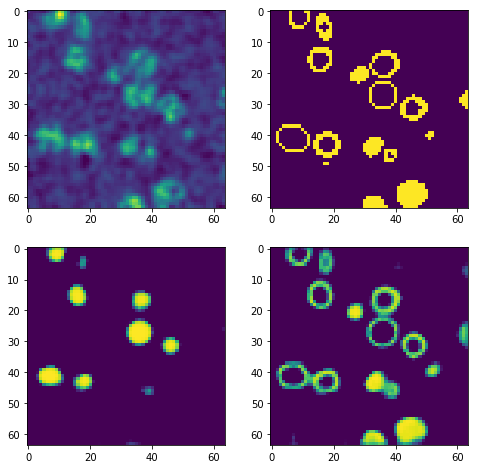

In [31]:
z=2
f,axes=plt.subplots(2,2, figsize=(8,8))
ix=random.randint(1,90)
print(ix)
ix=0
axes[0,0].imshow(sub_validation_data[ix,z,:,:])
axes[0,1].imshow(sub_validation_truth[ix,z,:,:,1])
axes[1,0].imshow((0.01+results[ix,z,:,:,0]))
axes[1,1].imshow((0.01+results[ix,z,:,:,1]))
z=z+1



Trying on Bony images

In [94]:
sub_validation_data.shape

(100, 64, 64)

In [130]:
blobs=read_tiff('BonyStack.tif',32)
blobs=blobs.reshape([1,32,64,64])
blobs=(blobs-np.mean(blobs))/np.std(blobs)
blobs=((blobs*.34+0.13))
blobgarb=sub_validation_truth[0:1,:,:,:,:]
print(np.mean(blobs))
print(np.std(blobs))
blobgarb.shape
blobs.shape

0.13
0.34


(1, 32, 64, 64)

In [131]:
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:blobs, y:blobgarb})

7

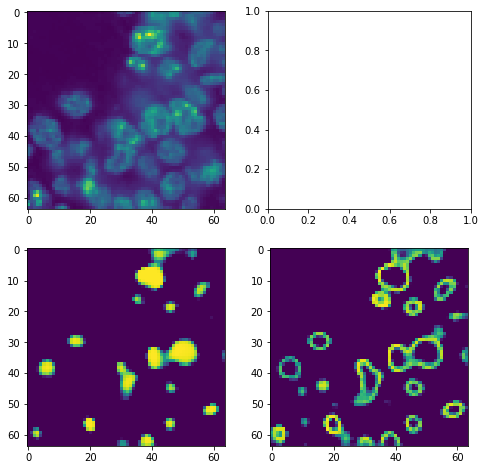

In [133]:
z=5

f,axes=plt.subplots(2,2, figsize=(8,8))
axes[0,0].imshow(blobs[0,z,:,:])
#axes[0,1].imshow(blobgarb[0,:,:,1])
axes[1,0].imshow((0.01+results[0,z,:,:,0]))
axes[1,1].imshow((0.5+results[0,z,:,:,1]))
ix=ix+1
ix

In [121]:
for i in range(0,32):
    im=Image.fromarray(results[0,i,:,:,0])
    im.save('output/MaskB'+str(i)+'.tif', "TIFF")
    im=Image.fromarray(results[0,i,:,:,1])
    im.save('output/OutlineB'+str(i)+'.tif', "TIFF")
